# Attention
* Alexandr Panin, Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```,
* Based on https://github.com/ebenolson/pydata2015


<h1 align="center"> Part I: Attention mechanism at toy problems </h1> 

<img src="https://s2.postimg.org/pq18f5t7t/deepbb.png" width=480>

In this seminar you will implement attention mechanism and apply it to a simple task of associative recall.

# Install me:
```(bash)
sudo pip install --upgrade https://github.com/yandexdataschool/agentnet/archive/master.zip
```


In [1]:
import lasagne
import numpy as np
from lasagne.layers import *
import matplotlib.pyplot as plt
import theano,theano.tensor as T

%matplotlib inline

## Problem description:

You are given a sequence of pairs [key,value]. 

Both keys and values are one-hot encoded integers. 

The network should learn to generate values in order of ascension of keys.


In [12]:
CODE_SIZE = 10
def generate_sample(min_length = 3, max_length = 10, code_size=CODE_SIZE):
    assert code_size >= max_length
    length = np.random.randint(min_length, max_length)
    
    keys = np.random.permutation(length)
    values = np.random.permutation(length)
    input_pairs = zip(keys,values)
    
    input_1hot = np.zeros([length+1,code_size*2])
    for i,(k,v) in enumerate(input_pairs):
        input_1hot[i+1][k] = 1
        input_1hot[i+1][code_size + v] = 1
    
    sorted_pairs = sorted(input_pairs,key=lambda k,v:k)
    
    target_1hot = np.zeros([length+1,code_size*2])
    for i,(k,v) in enumerate(sorted_pairs):
        target_1hot[i+1][k] = 1
        target_1hot[i+1][code_size + v] = 1
    
    
    return input_1hot,target_1hot

In [13]:
inp,out = generate_sample(max_length=5,code_size=5)
print ('-'*9 + "KEY" + '-'*9 + ' ' + '+'*9 + "VAL" + "+"*9)
print ("Input pairs:\n",inp)
print ("Target pairs:\n",out)

---------KEY--------- +++++++++VAL+++++++++
Input pairs:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]]
Target pairs:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


### Attention!

We're now going to implement attention mechanism, or more specifically, _additive attention_ (a.k.a. Bahdanau's attention).

We'll do so in two steps:

* __AttentionWeights(encoder_seq,attn_query)__ - a layer that returns attention weights (aka probabilities of taking each value).
* __AttentionOutput(encoder_seq,attn_weights)__ - a layer that averages inputs given probabilities from AttentionWeights.

If you're not feeling familiar with this procedure, just follow the step-by-step instructions in code.

In [21]:
from lasagne.init import Normal
class AttentionWeights(MergeLayer):
    def __init__(self, encoder_seq, attn_query, num_units):
        MergeLayer.__init__(self, [encoder_seq, attn_query])
        
        enc_units = encoder_seq.output_shape[2]
        dec_units = attn_query.output_shape[1]
        
        self.W_enc = self.add_param(Normal(), (enc_units, num_units), name='enc_to_hid')
        self.W_query = self.add_param(Normal(), (dec_units, num_units), name='dec_to_hid')
        self.W_out = self.add_param(Normal(), (num_units, 1),name='hid_to_logit')
    
    def get_output_for(self, inputs):
        # the encoder_sequence shape = [batch, time,units]
        # the query shapeshape  = [batch, units]
        encoder_sequence, query = inputs
        
        # Hidden layer activations, shape [batch,seq_len,hid_units]
        
        query_to_hid = query.dot(self.W_query)[:,None,:]
        
        enc_to_hid = encoder_sequence.dot(self.W_enc)
        
        hid = T.tanh(enc_to_hid+query_to_hid)
        
        # Logits from hidden, [batch_size, seq_len]
#         logits = hid.dot(self.W_out)[:,None,:]
        logits = hid.dot(self.W_out)[:,:,0]
        
        assert logits.ndim ==2, "Logits must have shape [batch,time] and be 2-dimensional."\
                                "Current amount of dimensions:"+str(logits.ndim)
        
        attn_weights = T.nnet.softmax(logits)
        
        return attn_weights
    
    def get_output_shape_for(self,input_shapes):
        enc_shape,query_shape = input_shapes
        return enc_shape[:-1]

In [24]:
class AttentionOutput(MergeLayer):
    def __init__(self, encoder_seq, attn_weights):
        MergeLayer.__init__(self,[encoder_seq,attn_weights])
    
    def get_output_for(self,inputs):
        # encoder_sequence shape = [batch,time,units]
        # attn_weights shape = [batch,time]
        encoder_sequence, attn_weights = inputs
    
        #Reshape attn_weights to make 'em 3-dimensional: [batch,time,1] - so you could multiply by encoder sequence
        attn_weights = attn_weights.reshape([attn_weights.shape[0],attn_weights.shape[1],1])
        
        #Compute attention response by summing encoder elements with weights along time axis (axis=1)
        attn_output = T.sum(encoder_sequence*attn_weights[:,:,None],axis=1)
        
        return attn_output
    
    def get_output_shape_for(self,input_shapes):
        enc_shape,query_shape = input_shapes
        return (enc_shape[0],enc_shape[-1])

We now define a single step of recurrent neural network using attention

In [25]:
input_sequence = T.itensor3("Input tokens [batch,time,code]")
reference_answers = T.itensor3("Reference answers[batch,time,code]")

l_inputs = InputLayer((None,None,CODE_SIZE*2),input_sequence)
l_prev_answers = InputLayer((None,None,CODE_SIZE*2),reference_answers[:,:-1])

In [26]:
from agentnet.memory import RNNCell
class step:
    prev_output = InputLayer((None, CODE_SIZE*2), name='previous output')
    input_sequence = InputLayer((None, None, CODE_SIZE*2), name='input sequence for attention')
    prev_rnn = InputLayer((None, 64), name='last rnn state')
    
    #TODO your code here
    attention_weights = AttentionWeights(input_sequence, prev_rnn,32)
    attention_value = AttentionOutput(input_sequence, attention_weights)
    
    new_rnn = RNNCell(prev_rnn,concat([attention_value, prev_output]))
    
    output_probs = DenseLayer(
        concat([new_rnn,attention_value]),
        num_units=CODE_SIZE*2, nonlinearity=T.nnet.sigmoid)

In [32]:
from agentnet import Recurrence
#This layer applies RNN to itself in a symbolic loop.
#Please wait for DeepBayes' staff to explain how it works.

rnn = Recurrence(
    input_sequences    = {step.prev_output: l_prev_answers},
    input_nonsequences = {step.input_sequence: l_inputs},
    state_variables    = {step.new_rnn: step.prev_rnn},
    tracked_outputs    = [step.output_probs,step.attention_weights],
    unroll_scan=False,
)

In [33]:
output_probs,attn_weights = get_output(
    [rnn[step.output_probs], rnn[step.attention_weights]])

predict = theano.function(
    [input_sequence,reference_answers],
    [output_probs,attn_weights],
    allow_input_downcast=True)

In [34]:
next_answers = reference_answers[:,1:]

loss = -T.log(output_probs)*next_answers -T.log(1-output_probs)*(1-next_answers)
loss = T.mean(loss)

updates = lasagne.updates.adam(loss, get_all_params(rnn))
train = theano.function([input_sequence, reference_answers], loss, updates=updates,allow_input_downcast=True)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', Reshape{2}.0, Reshape{2}.0, TensorType(float64, col), TensorType(float64, matrix), 'local_reshape_dimshuffle') local_reshape_dimshuffle
ERROR (theano.gof.opt): Optimization failure due to: local_reshape_dimshuffle
ERROR (theano.gof.opt): node: Reshape{2}(InplaceDimShuffle{0,x}.0, <TensorType(int64, vector)>)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/theano/gof/opt.py", line 2022, in process_node
    remove=remove)
  File "/opt/conda/lib/python3.6/site-packages/theano/gof/toolbox.py", line 391, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/opt/conda/lib/python3.6/site-packages/theano/gof/toolbox.py", line 340, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbo

### Training

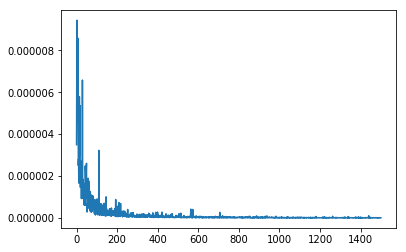

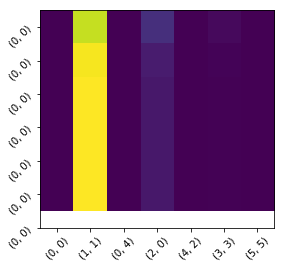

In [35]:
from tqdm import tnrange
from IPython.display import clear_output
loss_history = []

for i in tnrange(2000):
    bx,by = generate_sample()
    loss_history.append(train([bx],[by]))
    
    if i%500==0:
        clear_output(True)
        plt.plot(loss_history)
        plt.show()
        
        #draw attention map
        bx,by = generate_sample()
        probs,attentions = predict([bx],[by])

        input_kv = zip(bx[:,:CODE_SIZE].argmax(-1),bx[:,CODE_SIZE:].argmax(-1))
        target_kv = zip(by[:,:CODE_SIZE].argmax(-1),by[:,CODE_SIZE:].argmax(-1))
        plt.imshow(attentions[0])
        plt.xticks(*zip(*enumerate(map(str,input_kv))),rotation=45)
        plt.yticks(*zip(*enumerate(map(str,target_kv))),rotation=45)
        plt.show()